In [1]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward as ak
import time

import subprocess
GIT_REPO = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
sys.path.append(GIT_REPO + '/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import *

import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [2]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()

# for data_year in ['2022','2023','all']:
for data_year in ['all']:

    # path = "/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/data/raw/"
    # fpath_bkg[data_year] = path + f"data_{data_year}_goodLumi.root"
    if data_year == 'all':path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/'
    else: path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data{data_year}/v14/normalized/'
    if data_year == '2022':fpath['data'+data_year] = path + "DisplacedJet-EXOCSCCluster_Run2022-PromptReco_goodLumi.root"
    elif data_year == '2023':fpath['data'+data_year] = path + "Muon-EXOCSCCluster_Run2023-PromptReco_goodLumi.root"
    elif data_year == 'all':fpath['data'+data_year] = path + "EXOCSCCluster_Run2022_2023_goodLumi.root"

fpath['sig'] = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root'
NEvents = {}

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'].values()[0]
    # NEvents[k] = root_dir['NEvents'].counts()
    print("NEvents",NEvents[k])


dataall /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v14/normalized/EXOCSCCluster_Run2022_2023_goodLumi.root
NEvents 34804216.0
sig /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v14/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57555044.0
CPU times: user 371 ms, sys: 4.59 ms, total: 376 ms
Wall time: 375 ms


# apply selections

In [4]:
%%time


JET_PT_CUT = 30

cscRechitClusterEta = {}
cscRechitClusterPhi0 = {}
cscRechitClusterPhi1 = {}
cscRechitClusterDNN0  = {}
cscRechitClusterDNN1  = {}
cscRechitClusterTime0  = {}
cscRechitClusterTime1  = {}
cscRechitClusterSize0  = {}
cscRechitClusterSize1  = {}
deltaR_cluster = {}
deltaEta_cluster = {}
deltaPhi_cluster  = {}

HMTEff = {}
weight = {}

region_list = ['invertDNN', 'oot', 'signal']
for region in region_list:
    for tree_k in tree.keys():
        # if not region == 'signal': continue
        T = tree[tree_k]
        k = f'{region}_{tree_k}'


    ########### SELECTION: CLUSTERS ############
        me1 = (T['cscRechitClusterNRechitChamberPlus11'].array()+ T['cscRechitClusterNRechitChamberPlus12'].array()+\
        T['cscRechitClusterNRechitChamberMinus11'].array()+ T['cscRechitClusterNRechitChamberMinus12'].array())

        # cluster = 
        #one cluster to pass trigger
        # cluster0 = np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, T['cscRechitClusterTimeWeighted'].array() > -5)
        cluster = (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster = cluster & (me1 ==0)
        cluster = cluster & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster = cluster & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > JET_PT_CUT) & T['cscRechitClusterMuonVetoGlobal'].array())    

    ########### SELECTION: EVENTS ############
        sel_ev = T['HLT_CSCCSC'].array()
        # sel_ev  = np.logical_and(sel_ev,np.sum(cluster0, axis = 1) >= 1)
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster, axis = 1) == 2)

        cluster_pass_HLT = HLT_CSC(T['cscRechitClusterEta'].array(),T['cscRechitClusterNStation10'].array(),T['cscRechitClusterSize'].array())
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster_pass_HLT, axis = 1) >= 1) # at least one passes HLT
        
        # if met_cat == 'lowMET':sel_ev = np.logical_and(sel_ev ,T['met'].array() < 150)
        # else: sel_ev = sel_ev & (T['met'].array() > 150) & (T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev ,T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev,T['nCscRechitClusters'].array()==2)
        # print(np.count_nonzero(temp), np.count_nonzero(sel_ev))

    ########### BRANCHES ############
       ##### event variables ##### 
       
        cscRechitClusterPhi0[k] = T['cscRechitClusterPhi'].array()[cluster][sel_ev][:,0]
        cscRechitClusterPhi1[k] = T['cscRechitClusterPhi'].array()[cluster][sel_ev][:,1]
        deltaPhi_cluster[k] = deltaPhi(np.array(cscRechitClusterPhi0[k]), np.array(cscRechitClusterPhi1[k]))
        cscRechitClusterDNN0[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[cluster][sel_ev][:,0]
        cscRechitClusterDNN1[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[cluster][sel_ev][:,1]
        cscRechitClusterTime0[k] = T['cscRechitClusterTimeWeighted'].array()[cluster][sel_ev][:,0]
        cscRechitClusterTime1[k] = T['cscRechitClusterTimeWeighted'].array()[cluster][sel_ev][:,1]
        cscRechitClusterSize0[k] = T['cscRechitClusterSize'].array()[cluster][sel_ev][:,0]
        cscRechitClusterSize1[k] = T['cscRechitClusterSize'].array()[cluster][sel_ev][:,1]
        
        
        sel = (np.abs(deltaPhi_cluster[k])>1.8)
        sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterTime0[k]>-5) & (cscRechitClusterTime0[k]<12.5)
        if 'oot' in region:
            sel = sel & (cscRechitClusterDNN1[k] > 0.96) & (cscRechitClusterTime1[k]<-12.5)
        elif 'invertDNN' in region:
            sel = sel & (cscRechitClusterDNN1[k] < 0.96) & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        elif 'signal' in region:
            sel = sel & (cscRechitClusterDNN1[k] > 0.96) & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        else: assert(False)
        
        cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[cluster][sel_ev][sel]

            
        deltaPhi_cluster[k] = deltaPhi_cluster[k][sel]
        deltaR_cluster[k] = ((cscRechitClusterEta[k][:,0]-cscRechitClusterEta[k][:,1])**2 + deltaPhi_cluster[k]**2)**0.5
        deltaEta_cluster[k] = cscRechitClusterEta[k][:,0]-cscRechitClusterEta[k][:,1]
            
            
        cscRechitClusterSize1[k] = cscRechitClusterSize1[k][sel]
        HMTEff[k] = T['cscRechitClusterHMTEfficiency'].array()[sel_ev][sel]
        
        cluster_pass_HLT = cluster_pass_HLT[sel_ev][sel]
        HMTEff[k] = 1-HMTEff[k][cluster_pass_HLT]
        HMTEff[k] = 1-np.prod(HMTEff[k],axis=1)
        
        

        if 'data' in k:weight[k] = (T['weight'].array())[sel_ev][sel]*0.0 + 1                                                             
        else: weight[k] = (T['pileupWeight'].array()*T['weight'].array())[sel_ev][sel]*HMTEff[k]
        print("correlation between two variables:", k, scipy.stats.pearsonr(deltaPhi_cluster[k], cscRechitClusterSize1[k]))
        print("events in this region:", k, len(deltaPhi_cluster[k]), np.sum(weight[k]), len(weight[k]))

correlation between two variables: invertDNN_dataall (0.017157299541374915, 0.6425940546819275)
events in this region: invertDNN_dataall 734 734.0 734
correlation between two variables: invertDNN_sig (0.025081351586636852, 0.5831893224502569)
events in this region: invertDNN_sig 481 389.25403 481
correlation between two variables: oot_dataall (0.006391030979762313, 0.8834102646391727)
events in this region: oot_dataall 529 529.0 529
correlation between two variables: oot_sig (0.2159706376219362, 0.7840293623780639)
events in this region: oot_sig 4 2.949815 4
correlation between two variables: signal_dataall (0.06967265953245086, 0.2686108100105263)
events in this region: signal_dataall 254 254.0 254
correlation between two variables: signal_sig (0.01007057928935935, 0.6115209095441801)
events in this region: signal_sig 2546 2298.4578 2546
CPU times: user 47.5 s, sys: 6.45 s, total: 53.9 s
Wall time: 54 s


# Plot 1D distributions

invertDNN_dataall 0.6062176
oot_dataall 0.5968992
signal_sig 0.97884095
0.06896758079528809


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/deltaR.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/deltaR.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/deltaR.C has been generated


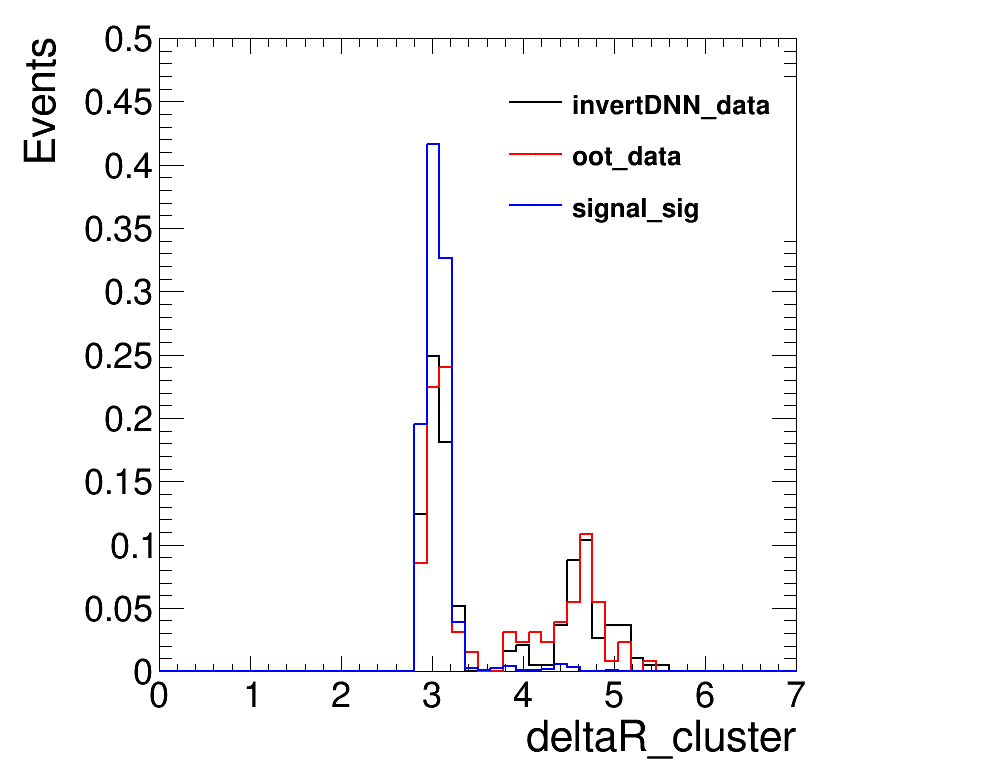

In [38]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
leg = rt.TLegend(0.5,0.7,0.8,0.9)
leg.SetBorderSize(0)
plot_var = [cscRechitClusterSize1, deltaPhi_cluster, deltaR_cluster, deltaEta_cluster]
axis = ['N_{rechits}','#Delta#phi', "deltaR_cluster","deltaEta_cluster"]
name = ['nhits','dphi', "deltaR", "deltaEta_cluster"]
bins = [[25,50,500],[25,1.8,3.2], [50,0,7], [50,0,10]]

plot_index = 2
i = 0
for k in plot_var[plot_index].keys():
    if  'signal_data' in k:continue
    if 'invertDNN_sig' in k or 'oot_sig' in k:continue
    # h = create_TH2D(np.column_stack(( np.array(cscRechitClusterSize1[k]), np.abs(deltaPhi_cluster[k]))),
                   # axis_title = ['N_{rechits}','#Delta#phi','Events'], binning=[25,50,500,25,1.8,3.2])
    cond = np.abs(deltaPhi_cluster[k])>2.8
    h[k] = create_TH1D( np.abs(np.array(plot_var[plot_index][k][cond])), axis_title = [axis[plot_index],'Events'], binning=bins[plot_index],weights = np.array(weight[k][cond]))
    check = deltaR_cluster[k]<3.5
    print(k, np.sum(weight[k][cond&check])/np.sum(weight[k][cond]))
    # if plot_index == 0:h[k].SetMinimum(0.1)
    # else: h[k].SetMinimum(500)
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(0.5)
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k],k.replace('all',''))
    h[k].Draw('hist same')
    i+=1
c.SetRightMargin(0.2)

# print(k, h[k].Integral(), len(cscRechitClusterSize1[k]))
# if selog: 
if plot_index == 0:c.SetLogy()
leg.Draw()
c.Draw()

c.SaveAs(GIT_REPO + "/plots/ABCD/"+name[plot_index]+".png")
c.SaveAs(GIT_REPO + "/plots/ABCD/"+name[plot_index]+".pdf")
c.SaveAs(GIT_REPO + "/plots/ABCD/"+name[plot_index]+".C")
    



print(time.time()-start_t)

In [27]:
for k in deltaR_cluster.keys():
    print(k, np.max(deltaR_cluster[k]), np.min(deltaR_cluster[k]))

invertDNN_dataall 5.498593 1.801784
invertDNN_sig 4.6518526 1.8105105
oot_dataall 5.349432 1.8874137
oot_sig 5.246967 3.325611
signal_dataall 5.400476 1.8248869
signal_sig 4.9198375 1.8020736


# distribution of dphi and Nrechits

invertDNN_dataall 734.0 734
invertDNN_sig 455.0 481
oot_dataall 529.0 529
oot_sig 4.0 4
signal_dataall 252.0 254
signal_sig 2271.0 2546
0.37143564224243164


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_dataall.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_dataall.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_dataall.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/invertDNN_sig.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0

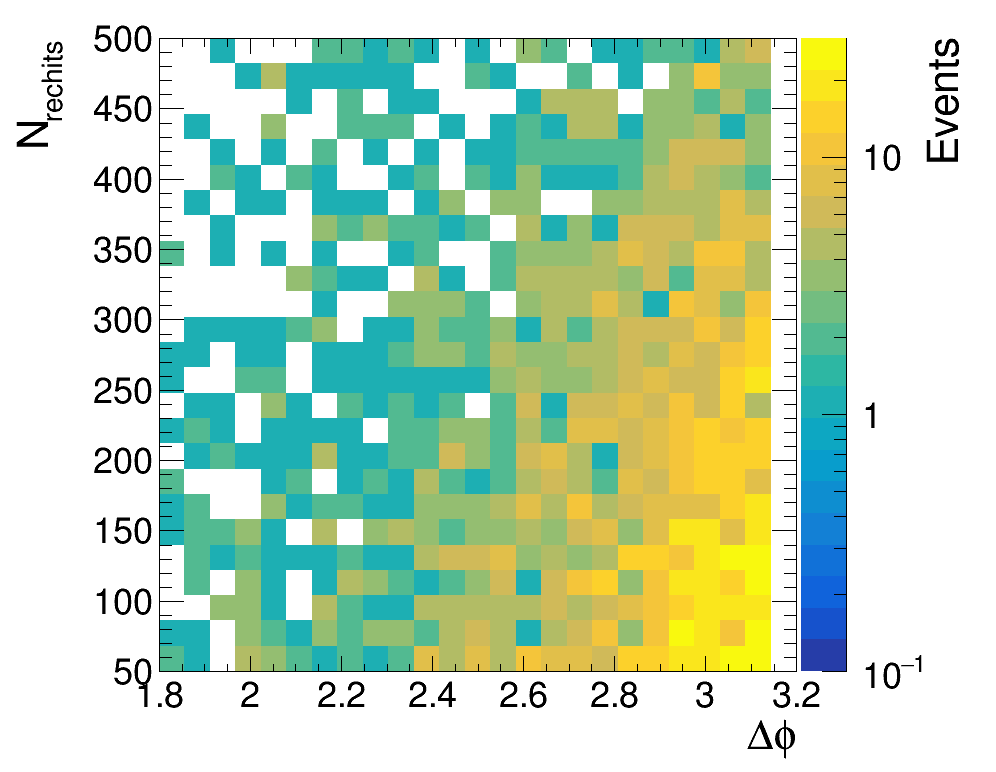

In [5]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)

for k in cscRechitClusterSize1.keys():
    # h = create_TH2D(np.column_stack(( np.array(cscRechitClusterSize1[k]), np.abs(deltaPhi_cluster[k]))),
                   # axis_title = ['N_{rechits}','#Delta#phi','Events'], binning=[25,50,500,25,1.8,3.2])
    
    h = create_TH2D(np.column_stack(( np.abs(deltaPhi_cluster[k]), np.array(cscRechitClusterSize1[k]), )),
                   axis_title = ['#Delta#phi','N_{rechits}','Events'], binning=[25,1.8,3.2,25,50,500,])

    h.SetMinimum(0.1)
    h.Draw('colz')
    c.SetRightMargin(0.2)

    print(k, h.Integral(), len(cscRechitClusterSize1[k]))
    # if setlog: 
    c.SetLogz()
    c.Draw()

    c.SaveAs(GIT_REPO + "/plots/ABCD/"+k+".png")
    c.SaveAs(GIT_REPO + "/plots/ABCD/"+k+".pdf")
    c.SaveAs(GIT_REPO + "/plots/ABCD/"+k+".C")
    



print(time.time()-start_t)

# ABCD (Scan Nrechits)

In [5]:
a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(60,300,10)
# cuts = np.arange(90,150,1)
n_ev = 5000


# cuts = [90,95,100,104,105]
print(cuts)
bkg_dphiJet = []
sig_dphiJet = []
bkg_dphiCluster = []
sig_dphiCluster = []
print_jetmet = 0
DPHI_CUT = 2.8

table = {}
latex_table = {}

for k in cscRechitClusterSize1.keys():
    if "sig" in k:continue
    print("*****************************")
    print(f"******** {k} **********")
    print("*****************************")
    table[k] = {
    # "dPhi cuts": ['dphi', 'A', 'B', 'C', 'D', 'prediction', 'uncertainty'],
    "Nhits cuts":[],
    "A": [],
    "B": [],
    "C": [],
    "D": [],
    "pred":[],
    "uncertainty":[],
    }
    for N_RECHIT_CUT in cuts:
        if N_RECHIT_CUT<100:continue
        var = np.abs(deltaPhi_cluster[k])
        
        a[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
        c[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var>=DPHI_CUT)])


        if b[k] == 0 or c[k] == 0 or d[k] ==0:break
        pred = b[k]*d[k]/c[k]
        unc_pred = (1./c[k] + 1./b[k] + 1./d[k])**0.5*pred
        if math.isnan(unc_pred): z_value = float("nan")
        else:
            mu = np.random.normal(pred, unc_pred, n_ev)
            p_value = 0.0
            for i in mu:
                if i < 0:continue
                n = np.random.poisson(i, n_ev)
                p_value += np.count_nonzero(n>=a[k])

            p_value = p_value/n_ev**2
            z_value = abs(norm.ppf(p_value))
        print(N_RECHIT_CUT, '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              round( unc_pred, 2), '\t', round(z_value,2))

        table[k]['Nhits cuts'].append(DPHI_CUT)
        table[k]['A'].append(a[k])
        table[k]['B'].append(b[k])
        table[k]['C'].append(c[k])
        table[k]['D'].append(d[k])
        table[k]['pred'].append(pred)
        table[k]['uncertainty'].append(unc_pred)
        
        
        
    table[k] = pd.DataFrame(table[k])
    latex_table[k] = table[k].to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    column_format="|l|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.2f}".format  # Formats floats to two decimal places
    )

    print(latex_table[k])

[ 60  70  80  90 100 110 120 130 140 150 160 170 180 190 200 210 220 230
 240 250 260 270 280 290]
*****************************
******** invertDNN_dataall **********
*****************************
100 	 17 	 62 	 479 	 176 	 22.78 	 3.52 	 1.07
110 	 15 	 43 	 498 	 178 	 15.37 	 2.7 	 0.13
120 	 14 	 32 	 509 	 179 	 11.25 	 2.22 	 0.61
130 	 10 	 20 	 521 	 183 	 7.02 	 1.68 	 0.82
140 	 7 	 15 	 526 	 186 	 5.3 	 1.44 	 0.51
150 	 6 	 11 	 530 	 187 	 3.88 	 1.22 	 0.76
160 	 5 	 7 	 534 	 188 	 2.46 	 0.95 	 1.1
170 	 5 	 7 	 534 	 188 	 2.46 	 0.95 	 1.09
180 	 5 	 6 	 535 	 188 	 2.11 	 0.88 	 1.32
190 	 2 	 5 	 536 	 191 	 1.78 	 0.81 	 0.0
200 	 2 	 4 	 537 	 191 	 1.42 	 0.72 	 0.24
210 	 1 	 3 	 538 	 192 	 1.07 	 0.62 	 0.24
220 	 1 	 3 	 538 	 192 	 1.07 	 0.62 	 0.27
230 	 1 	 1 	 540 	 192 	 0.36 	 0.36 	 0.56
240 	 1 	 1 	 540 	 192 	 0.36 	 0.36 	 0.57
250 	 1 	 1 	 540 	 192 	 0.36 	 0.36 	 0.53
260 	 1 	 1 	 540 	 192 	 0.36 	 0.36 	 0.56
270 	 0 	 1 	 540 	 193 	 0.3

# ABCD (Scan dPhi)

In [6]:

a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(0,35,2)/10
cuts = np.arange(1.8,3.2,0.05)
print(cuts)
n_ev = 5000


table = {}
latex_table = {}

N_RECHIT_CUT = 190
for k in cscRechitClusterSize1.keys():
    if "sig" in k:continue
    print("*****************************")
    print(f"******** {k} **********")
    print("*****************************")
    table[k] = {
        # "dPhi cuts": ['dphi', 'A', 'B', 'C', 'D', 'prediction', 'uncertainty'],
        "dPhi cuts":[],
        "A": [],
        "B": [],
        "C": [],
        "D": [],
        "pred":[],
        "uncertainty":[],
    }
    for DPHI_CUT in cuts:
        var = np.abs(deltaPhi_cluster[k])
        
        a[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var>=DPHI_CUT)])
        b[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]>=N_RECHIT_CUT, var<DPHI_CUT)])
        c[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var<DPHI_CUT)])
        d[k] = np.count_nonzero([np.logical_and(cscRechitClusterSize1[k]<N_RECHIT_CUT, var>=DPHI_CUT)])


        if b[k] == 0 or c[k] == 0 or d[k] ==0:continue
        pred = b[k]*d[k]/c[k]
        unc_pred = (1./c[k] + 1./b[k] + 1./d[k])**0.5*pred
        if math.isnan(unc_pred): z_value = float("nan")
        else:
            mu = np.random.normal(pred, unc_pred, n_ev)
            p_value = 0.0
            for i in mu:
                if i < 0:continue
                n = np.random.poisson(i, n_ev)
                p_value += np.count_nonzero(n>=a[k])

            p_value = p_value/n_ev**2
            z_value = abs(norm.ppf(p_value))
        print(round(DPHI_CUT,2), '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              round( unc_pred, 2), '\t', round(z_value,2))

        table[k]['dPhi cuts'].append(DPHI_CUT)
        table[k]['A'].append(a[k])
        table[k]['B'].append(b[k])
        table[k]['C'].append(c[k])
        table[k]['D'].append(d[k])
        table[k]['pred'].append(pred)
        table[k]['uncertainty'].append(unc_pred)
        
        
        
    table[k] = pd.DataFrame(table[k])
    latex_table[k] = table[k].to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    column_format="|l|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.2f}".format  # Formats floats to two decimal places
    )

    print(latex_table[k])


[1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45
 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15]
*****************************
******** invertDNN_dataall **********
*****************************
1.85 	 5 	 2 	 30 	 697 	 46.47 	 33.98 	 1.22
1.9 	 5 	 2 	 53 	 674 	 25.43 	 18.35 	 1.11
1.95 	 5 	 2 	 85 	 642 	 15.11 	 10.82 	 0.91
2.0 	 5 	 2 	 110 	 617 	 11.22 	 8.02 	 0.76
2.05 	 5 	 2 	 144 	 583 	 8.1 	 5.77 	 0.47
2.1 	 5 	 2 	 173 	 554 	 6.4 	 4.56 	 0.28
2.15 	 5 	 2 	 203 	 524 	 5.16 	 3.68 	 0.08
2.2 	 5 	 2 	 224 	 503 	 4.49 	 3.2 	 0.11
2.25 	 5 	 2 	 246 	 481 	 3.91 	 2.78 	 0.28
2.3 	 5 	 2 	 272 	 455 	 3.35 	 2.38 	 0.49
2.35 	 4 	 3 	 288 	 439 	 4.57 	 2.66 	 0.18
2.4 	 4 	 3 	 307 	 420 	 4.1 	 2.39 	 0.06
2.45 	 4 	 3 	 332 	 395 	 3.57 	 2.08 	 0.1
2.5 	 4 	 3 	 360 	 367 	 3.06 	 1.78 	 0.3
2.55 	 3 	 4 	 403 	 324 	 3.22 	 1.63 	 0.15
2.6 	 3 	 4 	 433 	 294 	 2.72 	 1.37 	 0.06
2.65 	 2 	 5 	 460 	 267 	 2.9 	 

In [ ]:
# Optimization
